# GridSearchCV - Random Forest Classifier

## Import Required Modules

In [1]:
%load_ext autoreload
%autoreload 2

## Import System tools

In [2]:
import os
import sys
import gc
import cProfile
import warnings

In [3]:
current_dir = os.getcwd()
helpers = os.path.join(current_dir, "helpers")
sys.path.insert(0,helpers)

## Importing libraries

In [4]:
from enum import Enum, IntEnum
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import seaborn as sns
import json
import pickle
from tabulate import tabulate
from logger import logger
import directory_manager as dm
import object_manager as om
import data_structures as ds
import df_manager as dfm
from data_model import Metrics, CSVHeader,HandWashingType
from filters import band_pass_filter
from sliding_window import get_windows
import features
from tqdm import tqdm
from collections import Counter

import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

from tsfresh.feature_extraction import extract_features

import sampler

2023-09-04 06:31:24 - INFO - Logger Created.


In [21]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import RobustScaler, MinMaxScaler

## Load files

In [6]:
# Load lists of csv files
data_folder = "features"
personalized_subject = "03"
csv_files = dm.get_files_names(dm.get_data_dir(data_folder))
grouped_files = ds.group_by_subjects(csv_files)
subjects = [key for key in grouped_files.keys()]
print(f"Total Subjects:{len(subjects)}")

subjects.remove(personalized_subject)
total_subjects = len(subjects)
print(f"Personalized Subject:{personalized_subject}")

#random.seed(52)
random.shuffle(subjects)
print(f"Shuffled:{subjects}")
total_train = int(0.85*total_subjects)

train_sub_ids = subjects[:total_train]
test_sub_ids = list(set(subjects)-set(train_sub_ids))

print(f"Train_set:{train_sub_ids}")
print(f"Test_set:{test_sub_ids}")

Total Subjects:22
Personalized Subject:03
Shuffled:['24', '10', '20', '22', '13', '27', '01', '07', '18', '25', '30', '02', '19', '05', '15', '21', '29', '04', '09', '11', '12']
Train_set:['24', '10', '20', '22', '13', '27', '01', '07', '18', '25', '30', '02', '19', '05', '15', '21', '29']
Test_set:['11', '09', '12', '04']


In [7]:
grouped_files = ds.group_by_subjects(csv_files)

train_set = {}
test_set = {}

for sub, files in grouped_files.items():
    if sub in train_sub_ids:
        train_set[sub] = files
    else:
        test_set[sub]=files

print(f"Train Set:{len(train_set)}")
print(f"Test Set: {len(test_set)}")

Train Set:17
Test Set: 5


In [8]:
train_files = [files[0] for files in train_set.values()]
test_files = [files[0] for files in test_set.values()]

In [9]:
df_train = dfm.load_all_files(train_files, data_folder, add_sub_id=True)
df_test = dfm.load_all_files(test_files, data_folder, add_sub_id=True)

Loading CSV Files:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:16<00:00,  1.04it/s]
2023-09-04 06:31:50 - INFO - 17 csv files loaded successfully. DataFrame Length:2407500
Loading CSV Files:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]
2023-09-04 06:31:54 - INFO - 5 csv files loaded successfully. DataFrame Length:624805


In [10]:
def plot_multiple_histograms(dataframes, names, num_cols=1):
    """
    Plots multiple histograms in rows within one figure.

    Args:
        dataframes (list): List of DataFrames, each containing label data in a single column.
        names (list): List of names corresponding to each DataFrame for labeling the subplots.
    """
    num_dataframes = len(dataframes)
    
    # Determine the number of rows and columns for subplots
    num_rows = num_dataframes//num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    for i, df in enumerate(dataframes):
        row = i//num_cols
        col = i%num_cols
        if col>2:
            ax = axes[row,col]
        else:
            ax = axes[row]
        ax.hist(df.iloc[:, -2], bins=len(df[df.columns[-2]].unique()), rwidth=0.8, alpha=0.7, color='skyblue')
        ax.set_xlabel('Labels')
        ax.set_ylabel('Frequency')
        ax.set_title(names[i])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
    # Remove empty subplots if any
    for i in range(num_dataframes, num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.show()

In [11]:
def plot_multiple_pies(dataframes, names, num_cols=1):
    """
    Plots multiple histograms in rows within one figure.

    Args:
        dataframes (list): List of DataFrames, each containing label data in a single column.
        names (list): List of names corresponding to each DataFrame for labeling the subplots.
    """
    num_dataframes = len(dataframes)
    
    labels = ['others', 'rHW', 'cHW']
    
    # Determine the number of rows and columns for subplots
    num_rows = num_dataframes//num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.subplots_adjust(hspace=0.5)
    
    # Colors for the pie chart
    colors = ["#47B39C", "#FFC154", "#EC6B56"]

    for i, df in enumerate(dataframes):
        other_totals = len(df[df["relabeled"]==0])
        rHW_totals = len(df[df["relabeled"]==1])
        cHW_totals = len(df[df["relabeled"]==2])
        category_counts = [other_totals, rHW_totals, cHW_totals]
        overall_percentages = [(count / len(df)) * 100 for count in category_counts]

        row = i//num_cols
        col = i%num_cols
        if num_rows==1 or num_cols ==1:
            ax = axes[i]
        else:
            ax = axes[row,col]
        
        #ax.pie(category_counts, labels=categories, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightpink'])
        #ax.axis('equal')
        wedges, _ ,_ = ax.pie(overall_percentages, colors=colors, startangle=90, autopct="",wedgeprops={'edgecolor': 'black'})

        # Create legend with values
        legend_labels = [f"{label}: {percentage:.1f}%" for label, percentage in zip(labels, overall_percentages)]
        ax.legend(wedges, legend_labels, loc="center", bbox_to_anchor=(0.5, -0.1))

        # Remove text from pie chart
        #ax.setp(wedges, width=0.4) 

        #ax.hist(category_counts, bins=categories, rwidth=0.8, alpha=0.7, color='skyblue')
        #ax.set_xlabel('Labels')
        #ax.set_ylabel('Frequency')
        ax.set_title(names[i])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        
    # Remove empty subplots if any
    for i in range(num_dataframes, num_rows * num_cols):
        fig.delaxes(axes[i // num_cols, i % num_cols])
    
    # Show the legend
    plt.axis('off')
    plt.show()

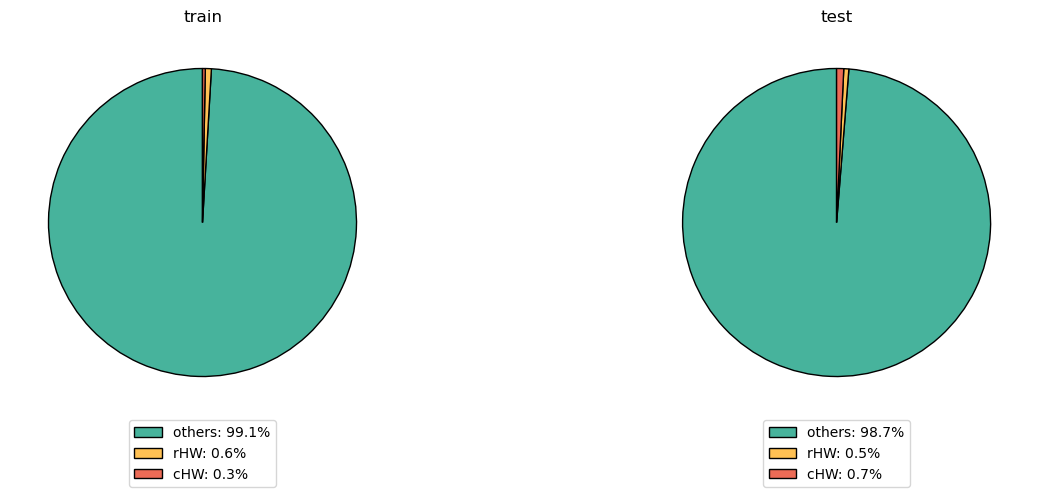

In [12]:
plot_multiple_pies([df_train, df_test], ["train","test"], num_cols=2)

In [13]:
# def sample(df, ratio=None):
#     if not ratio:
#         counts = df["relabeled"].value_counts()
#         total_hw = counts[1]+counts[2]
#         df_others = df[df["relabeled"]==0].iloc[:total_hw,:]
#         df_rHW = df[df["relabeled"]==1]
#         df_cHW = df[df["relabeled"]==2]
#         df_sampled = pd.concat([df_others,df_rHW,df_cHW], ignore_index=True)
#         print(Counter(df_sampled["relabeled"]))
#         return df_sampled

In [14]:
X_train = df_train.iloc[:,:-2]
y_train = df_train.iloc[:,-2]
X_test = df_test.iloc[:,:-2]
y_test = df_test.iloc[:,-2]

In [15]:
#train_sampled
X_train_sampled, y_train_sampled = sampler.underSample(X_train,y_train)
X_train_sampled, y_train_sampled = sampler.overSample(X_train_sampled, y_train_sampled)

2023-09-04 06:31:55 - INFO - Class distribution original: Counter({0: 2385300, 1: 15150, 2: 7050})
2023-09-04 06:31:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 1192650, 1: 15150, 2: 7050})
/home/atm/anaconda3/envs/dl23/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
2023-09-04 06:32:02 - INFO - Class distribution after oversampling: Counter({0: 1192650, 1: 1192650, 2: 1192650})


In [16]:
# Initialize RobustScaler and MinMaxScaler
scaler = MinMaxScaler()
# Fit scaler
X_train_scaled = scaler.fit_transform(X_train_sampled.values)
X_test_scaled = scaler.transform(X_test.values)

# Grid search cv

In [17]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_sampled), y=y_train_sampled)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight_dict)
# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(class_weight=class_weight_dict, n_jobs=12, verbose=3)

{0: 1.0, 1: 1.0, 2: 1.0}


In [19]:
param_grid = { 
    'n_estimators': [90, 100],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [5,8],
    'criterion' :['gini', 'entropy']
}

In [22]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, verbose=1, scoring="f1_macro")

In [23]:
CV_rfc.fit(X_train_scaled, y_train_sampled)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed: 15.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed: 15.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  6.0min
[Parallel(n

[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.5s
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.6s
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent worker

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 29.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:  3.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:    1.0s finished
[Parallel(n_jobs=

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   58.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   57.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  7.1min
[Parallel(n

[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   55.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   56.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent worker

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 33.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed: 34.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n

GridSearchCV(estimator=RandomForestClassifier(class_weight={0: 1.0, 1: 1.0,
                                                            2: 1.0},
                                              n_jobs=12, verbose=1),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 8],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [90, 100]},
             scoring='f1_macro', verbose=1)

In [24]:
print("Best parameters:", CV_rfc.best_params_)

# Get the best model
best_model = CV_rfc.best_estimator_

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}


In [35]:
om.save_object(CV_rfc.best_estimator_, 'models','ML_02-GridsearchCV_best_model.pkl')
om.save_object(CV_rfc,'models', 'ML_02-GridsearchCV.pkl')

'Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/models/ML_02-GridsearchCV.pt'

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished


F1 Score (Macro): 0.21571870017280415
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.45      0.62    616855
           1       0.01      0.17      0.01      3300
           2       0.01      0.38      0.01      4650

    accuracy                           0.45    624805
   macro avg       0.33      0.33      0.22    624805
weighted avg       0.97      0.45      0.61    624805



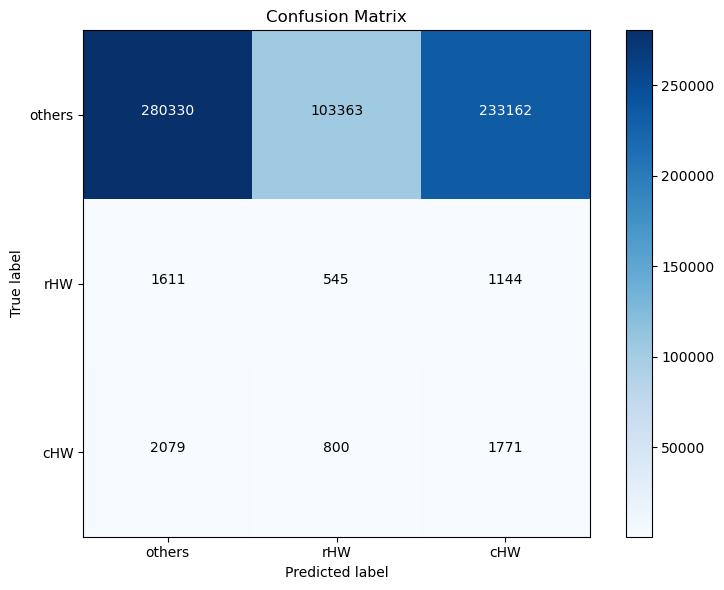

In [27]:
# Evaluate the model
f1_macro, classification_rep, cm = evaluate_model(best_model, X_test_scaled, y_test)
#f1_macro, classification_rep, cm = evaluate_model(clf, X_train, y_train)

print("F1 Score (Macro):", f1_macro)
print("Classification Report:\n", classification_rep)

# Plot the confusion matrix
class_names = ["others","rHW", "cHW"]
plot_confusion_matrix(cm, classes=class_names)

## Manual Random Forest

In [26]:
def train_random_forest(X_train, y_train, n_estimators=200, max_depth=None, random_state=None, n_jobs=12):
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    print(class_weight_dict)
    # Initialize the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state,
                                 class_weight=class_weight_dict, n_jobs=n_jobs)
    
    print("Training ML Classifier.")
    # Train the model
    clf.fit(X_train, y_train)
    return clf

def evaluate_model(clf, X_test, y_test):
    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate F1 score with macro averaging
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    # Generate a classification report
    classification_rep = classification_report(y_test, y_pred)

    # Generate a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return f1_macro, classification_rep, cm

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [30]:
# Train the Random Forest Classifier
clf = train_random_forest(X_train_scaled, y_train_sampled,n_estimators=100, random_state=25,n_jobs=12)

{0: 1.0, 1: 1.0, 2: 1.0}
Training ML Classifier.


In [29]:
personalized_sub = grouped_files['03']
df_infer = dfm.load_all_files(personalized_sub, data_folder, add_sub_id=True)
df_infer.head()

Loading CSV Files:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]
2023-09-05 20:40:56 - INFO - 1 csv files loaded successfully. DataFrame Length:154064


,acc x__median,acc x__standard_deviation,acc x__root_mean_square,acc x__maximum,acc x__minimum,acc x__skewness,acc x__kurtosis,acc x__abs_energy,acc x__sample_entropy,acc y__median,...,gyro z__standard_deviation,gyro z__root_mean_square,gyro z__maximum,gyro z__minimum,gyro z__skewness,gyro z__kurtosis,gyro z__abs_energy,gyro z__sample_entropy,relabeled,sub_id
0,-0.352387,0.675916,0.678352,1.553990,-1.319080,0.719845,-0.773780,69.024290,0.328007,-0.065983,...,0.115083,0.115232,0.309317,-0.317589,0.240810,1.260981,1.991755,0.666550,0,3
1,0.044136,0.548291,0.548293,1.667076,-1.526699,0.160459,0.996214,45.093785,0.161268,-0.020378,...,0.112668,0.113746,0.446066,-0.282841,1.207406,3.555771,1.940721,0.130993,0,3
2,-0.066680,0.346978,0.347008,2.154515,-0.583488,2.639119,13.515775,18.062186,0.411016,0.086192,...,0.099557,0.099580,0.391850,-0.371223,0.055620,4.587115,1.487431,0.466705,0,3
3,-0.037848,0.502128,0.502457,1.370265,-1.262163,0.025520,0.320017,37.869518,0.474866,-0.093293,...,0.441015,0.441015,1.523921,-2.181076,-0.782831,9.099355,29.174170,0.237383,0,3
4,0.009397,0.124688,0.124779,0.501504,-0.574644,-0.545348,4.897307,2.335455,0.977146,0.013072,...,0.029081,0.029093,0.135503,-0.106169,0.426931,4.619742,0.126963,0.916291,0,3


In [36]:
X_infer = df_infer.iloc[:,:-2]
y_infer = df_infer.iloc[:,-2]

In [37]:
X_infer_scaled = scaler.transform(X_infer.values)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


F1 Score (Macro): 0.24191917197043286
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.52      0.68    150464
           1       0.01      0.15      0.02      1800
           2       0.01      0.36      0.02      1800

    accuracy                           0.51    154064
   macro avg       0.33      0.34      0.24    154064
weighted avg       0.95      0.51      0.66    154064



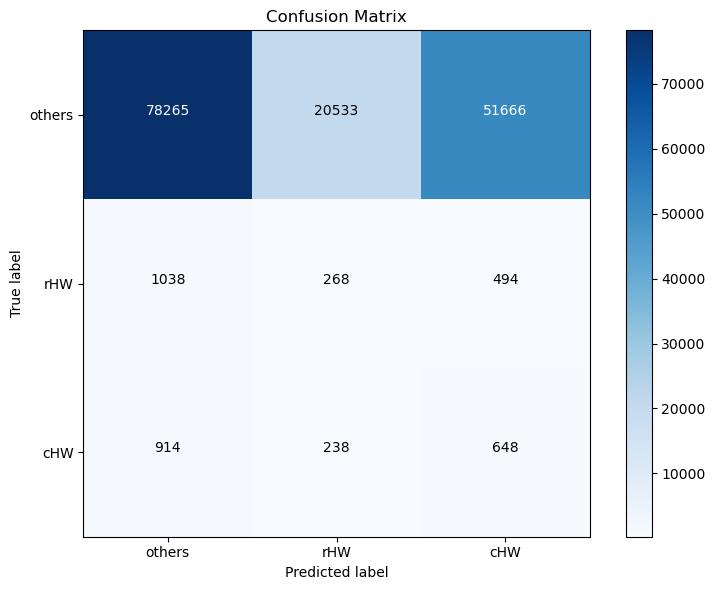

In [38]:
# Evaluate the model
f1_macro, classification_rep, cm = evaluate_model(best_model, X_infer_scaled, y_infer)

print("F1 Score (Macro):", f1_macro)
print("Classification Report:\n", classification_rep)

# Plot the confusion matrix
class_names = ["others","rHW", "cHW"]
plot_confusion_matrix(cm, classes=class_names)

## Load Best Model

In [44]:
# Load best model 
clf = om.load_object("models","ML_02-GridsearchCV_best_model.pt")
print(clf.get_params())
#clf = train_random_forest(X_train_scaled, y_train_sampled,n_estimators=150, random_state=25,n_jobs=12)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 1.0, 1: 1.0, 2: 1.0}, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 12, 'oob_score': False, 'random_state': None, 'verbose': 1, 'warm_start': False}


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


F1 Score (Macro): 0.21571870017280415
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.45      0.62    616855
           1       0.01      0.17      0.01      3300
           2       0.01      0.38      0.01      4650

    accuracy                           0.45    624805
   macro avg       0.33      0.33      0.22    624805
weighted avg       0.97      0.45      0.61    624805



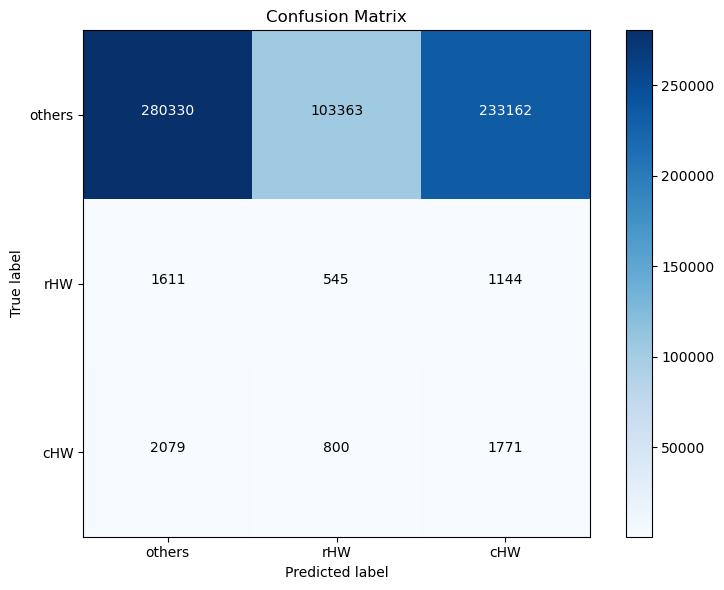

In [45]:
# Evaluate the model
f1_macro, classification_rep, cm = evaluate_model(clf, X_test_scaled, y_test)
#f1_macro, classification_rep, cm = evaluate_model(clf, X_train, y_train)

print("F1 Score (Macro):", f1_macro)
print("Classification Report:\n", classification_rep)

# Plot the confusion matrix
class_names = ["others","rHW", "cHW"]
plot_confusion_matrix(cm, classes=class_names)